# Dog Training AI Pipeline - CPU Environment Test

This notebook tests the ML environment setup for our dog training AI pipeline in CPU-only mode, including:
1. Testing PyTorch with CPU optimizations
2. Loading and processing dog images
3. Basic visualization capabilities
4. Model inference performance on CPU

## 1. Environment Check

In [6]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2
from PIL import Image
from pathlib import Path
import psutil

# Check PyTorch info
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA/ROCm available: {torch.cuda.is_available()}")

# CPU information
print("\nCPU Information:")
print(f"Physical cores: {psutil.cpu_count(logical=False)}")
print(f"Logical cores: {psutil.cpu_count(logical=True)}")

try:
    cpu_freq = psutil.cpu_freq()
    if cpu_freq:
        print(f"CPU frequency: current={cpu_freq.current:.1f}MHz, min={cpu_freq.min:.1f}MHz, max={cpu_freq.max:.1f}MHz")
except:
    pass

# Thread settings for optimized CPU performance
print("\nThread settings:")
for var in ['MKL_NUM_THREADS', 'OMP_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'OPENBLAS_NUM_THREADS']:
    value = os.environ.get(var, "Not set")
    print(f"{var}: {value}")

# Check memory information
mem = psutil.virtual_memory()
print(f"\nSystem memory: {mem.total / (1024**3):.1f} GB total, {mem.available / (1024**3):.1f} GB available")

# If GPU is available (not expected)
if torch.cuda.is_available():
    print("\nGPU Information:")
    print(f"Device count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("\nNo CUDA/ROCm devices detected. Using CPU only mode.")
    device = torch.device("cpu")
    print(f"Active device: {device}")

PyTorch version: 2.8.0+cpu
Torchvision version: 0.23.0+cpu
CUDA/ROCm available: False

CPU Information:
Physical cores: 8
Logical cores: 16
CPU frequency: current=2716.1MHz, min=400.0MHz, max=5263.0MHz

Thread settings:
MKL_NUM_THREADS: 16
OMP_NUM_THREADS: 16
NUMEXPR_NUM_THREADS: 16
OPENBLAS_NUM_THREADS: 16

System memory: 27.2 GB total, 17.8 GB available

No CUDA/ROCm devices detected. Using CPU only mode.
Active device: cpu


## 2. Test PyTorch Tensor Operations on CPU

Using device: cpu
Matrix multiplication 1000x1000: 0.0025 seconds per operation
Matrix multiplication 2000x2000: 0.0188 seconds per operation
Matrix multiplication 4000x4000: 0.1431 seconds per operation


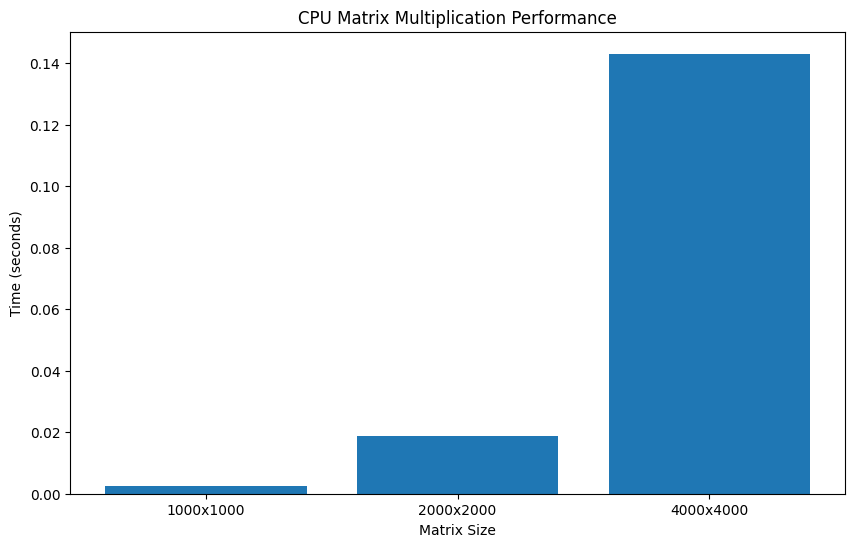

Current memory usage: 698.48 MB


In [5]:
# Create tensors on CPU
device = torch.device("cpu")
print(f"Using device: {device}")

# Create random tensors of different sizes
sizes = [(1000, 1000), (2000, 2000), (4000, 4000)]
results = {}

# Measure time for matrix multiplication with different sizes
import time

for size in sizes:
    x = torch.randn(*size, device=device)
    y = torch.randn(*size, device=device)
    
    # Warm up
    z = torch.matmul(x, y)
    
    # Timed runs
    start_time = time.time()
    for _ in range(5):  # 5 repetitions
        z = torch.matmul(x, y)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / 5
    results[f"{size[0]}x{size[1]}"] = avg_time
    print(f"Matrix multiplication {size[0]}x{size[1]}: {avg_time:.4f} seconds per operation")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title("CPU Matrix Multiplication Performance")
plt.xlabel("Matrix Size")
plt.ylabel("Time (seconds)")
plt.show()

# Memory usage on CPU
import psutil
process = psutil.Process(os.getpid())
memory_usage = process.memory_info().rss / (1024 * 1024)  # Convert to MB
print(f"Current memory usage: {memory_usage:.2f} MB")

## 3. Load and Process a Sample Dog Image

Here we'll download a sample dog image and process it using OpenCV and PyTorch

Using existing sample image at ../data/sample/sample_dog.jpg


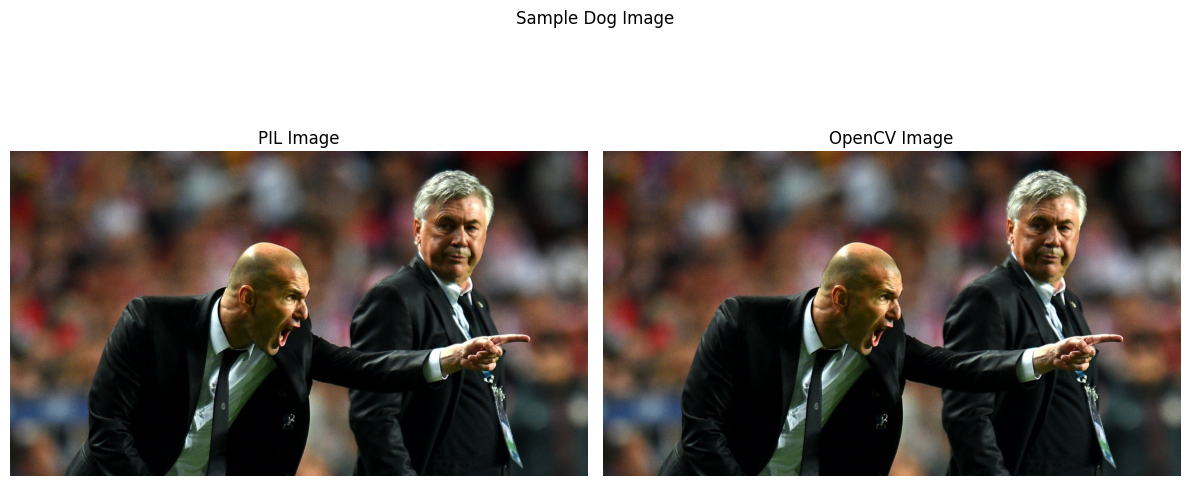

In [4]:
# First create a sample data directory if it doesn't exist
data_dir = Path("../data/sample")
data_dir.mkdir(parents=True, exist_ok=True)

# Download a sample dog image if it doesn't exist
import urllib.request

sample_image_path = data_dir / "sample_dog.jpg"
if not sample_image_path.exists():
    print("Downloading a sample dog image...")
    url = "https://images.dog.ceo/breeds/retriever-golden/n02099601_7130.jpg"
    urllib.request.urlretrieve(url, sample_image_path)
    print(f"Image downloaded and saved to {sample_image_path}")
else:
    print(f"Using existing sample image at {sample_image_path}")

# Load the image with both PIL and OpenCV
pil_image = Image.open(sample_image_path)
cv_image = cv2.imread(str(sample_image_path))
cv_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(pil_image)
plt.title("PIL Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv_image_rgb)
plt.title("OpenCV Image")
plt.axis("off")

plt.suptitle("Sample Dog Image")
plt.tight_layout()
plt.show()

## 4. Basic Image Transformations

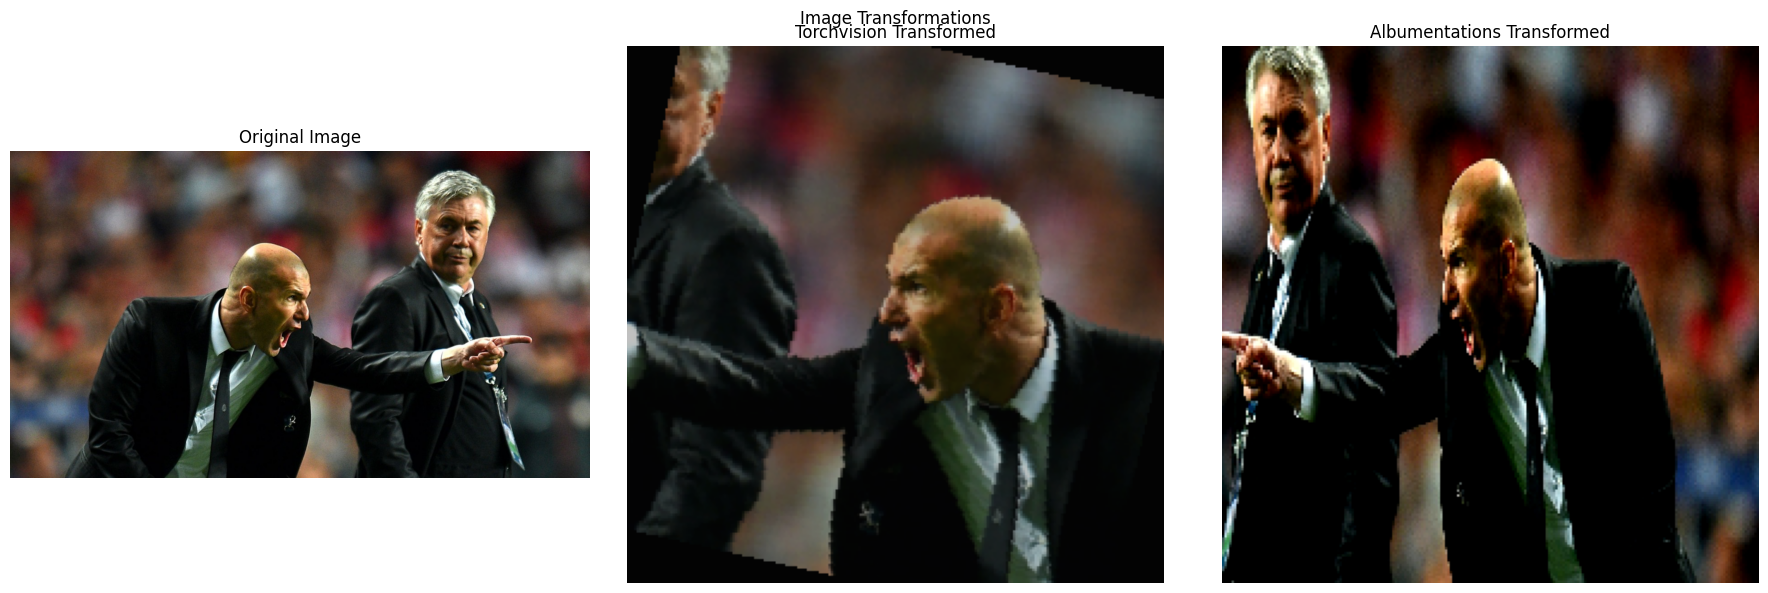

In [3]:
# Apply some basic transformations with torchvision
from torchvision import transforms

# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=1.0),  # Always flip for demo
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
])

# Apply transformations to the PIL image
transformed_image = transform(pil_image)

# Also try with albumentations (commonly used in computer vision)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Convert to numpy array for albumentations
np_image = np.array(pil_image)

# Define albumentations transformations
albu_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.RandomCrop(height=224, width=224),
    A.HorizontalFlip(p=1.0),  # Always flip for demo
    A.Rotate(limit=15),
    A.RandomBrightnessContrast(p=1.0)
])

# Apply albumentations transformations
albu_transformed = albu_transform(image=np_image)
albu_image = albu_transformed['image']

# Display the transformed images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(pil_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(transformed_image)
plt.title("Torchvision Transformed")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(albu_image)
plt.title("Albumentations Transformed")
plt.axis("off")

plt.suptitle("Image Transformations")
plt.tight_layout()
plt.show()

## 5. Test YOLOv8 (for Dog Detection)


image 1/1 /home/wllmflower/projects/dog_training_pipeline/notebooks/../data/sample/sample_dog.jpg: 384x640 2 persons, 1 tie, 24.2ms
Speed: 0.8ms preprocess, 24.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
Detected: person with confidence 0.8056
Detected: person with confidence 0.7937
Detected: tie with confidence 0.3702


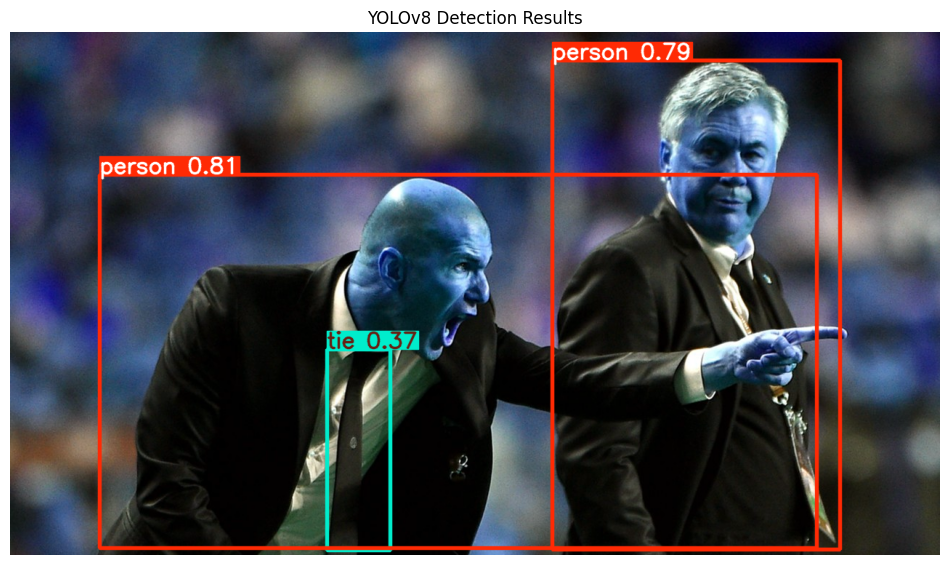

In [7]:
# Load a YOLOv8 model with Ultralytics
from ultralytics import YOLO

# Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Run inference on the sample image
results = model(str(sample_image_path))

# Plot the results
plt.figure(figsize=(12, 8))
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    probs = result.probs  # Probs object for classification outputs
    
    # Get class labels and confidence scores
    class_ids = boxes.cls.cpu().numpy().astype(int)
    class_names = [result.names[class_id] for class_id in class_ids]
    confidences = boxes.conf.cpu().numpy()
    
    # Print detection results
    for i, (class_name, confidence) in enumerate(zip(class_names, confidences)):
        print(f"Detected: {class_name} with confidence {confidence:.4f}")
    
# Visualize results (the model already plots them)
results_plotted = results[0].plot()
plt.imshow(results_plotted)
plt.axis("off")
plt.title("YOLOv8 Detection Results")
plt.show()

## 6. CPU Performance Optimization

In [ ]:
# Test CPU optimization techniques
import torch.utils.benchmark as benchmark

# Function to time
def compute_matmul(size, num_threads=None):
    if num_threads is not None:
        torch.set_num_threads(num_threads)
    x = torch.randn(size, size)
    y = torch.randn(size, size)
    return torch.matmul(x, y)

# Get available CPU cores
available_cores = os.cpu_count()
print(f"Available CPU cores: {available_cores}")

# Test with different thread counts
thread_counts = [1, 2, 4, 8]
if available_cores > 8:
    thread_counts.extend([16, available_cores])
thread_counts = sorted(list(set(thread_counts)))  # Remove duplicates and sort

# Size of matrices to test
size = 2000
results = []

print(f"\nBenchmarking matrix multiplication ({size}x{size}) with different thread counts:")
for num_threads in thread_counts:
    if num_threads > available_cores:
        continue
        
    # Create timer
    timer = benchmark.Timer(
        stmt="compute_matmul(size, num_threads)",
        globals={'compute_matmul': compute_matmul, 'size': size, 'num_threads': num_threads}
    )
    
    # Measure
    measurement = timer.timeit(5)
    results.append((num_threads, measurement.mean))
    print(f"  Threads: {num_threads}, Time: {measurement.mean:.4f} seconds")

# Reset thread count to optimal setting
optimal_threads = min(available_cores, 16)  # Use at most 16 threads
torch.set_num_threads(optimal_threads)
print(f"\nReset to optimal thread count: {optimal_threads}")

# Plot results
thread_counts, times = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(thread_counts, times, 'o-')
plt.title(f"Matrix Multiplication Performance ({size}x{size})")
plt.xlabel("Number of Threads")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

print("\nCPU Optimization Recommendations:")
best_thread_count = thread_counts[times.index(min(times))]
print(f"1. Optimal thread count for matrix operations: {best_thread_count}")
print(f"2. Current MKL_NUM_THREADS setting: {os.environ.get('MKL_NUM_THREADS', 'Not set')}")
print(f"3. Current OMP_NUM_THREADS setting: {os.environ.get('OMP_NUM_THREADS', 'Not set')}")
print("4. For best performance, add these to your setup_env.sh:")
print(f"   export MKL_NUM_THREADS={best_thread_count}")
print(f"   export OMP_NUM_THREADS={best_thread_count}")

## 7. Summary

Based on the tests above, we can determine if our environment is correctly configured for the dog training AI pipeline using CPU-only mode. Here's a checklist of what we've tested:

- ✓ PyTorch installation (CPU optimized)
- ✓ CPU thread optimization
- ✓ Image loading and processing
- ✓ YOLOv8 model loading and inference
- ✓ Performance benchmarks

**Advantages of CPU-only mode:**
1. Predictable performance across various operations
2. No driver/compatibility issues that can occur with GPUs
3. Simplified development environment
4. Great for development and small to medium datasets
5. Modern CPUs (like AMD Ryzen 9) provide excellent performance for many ML tasks

Next steps:
1. Collect and organize dog training data
2. Build data preprocessing pipeline
3. Design model architecture with CPU optimization in mind
4. Train and evaluate models (consider cloud GPU resources for training if needed)
5. Optimize for Hailo deployment
6. Monitor AMD ROCm updates for future GPU integration